## 模型介绍

1. 利用训练好的词向量构造句子


In [1]:
import keras 
from  os.path import join
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Lambda,Input,Merge,Flatten,Reshape,GlobalMaxPooling2D,MaxPooling2D
from keras.layers import Embedding
from keras.layers import Convolution1D
from keras.datasets import imdb
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D,Convolution2D,merge
from keras.utils import np_utils
from keras.models import Model
import numpy as np
from gensim.models import word2vec
from keras.regularizers import l2
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from keras.constraints import maxnorm
import pickle

Using Theano backend.
Using gpu device 0: GeForce GT 630 (CNMeM is disabled, cuDNN 5005)
/home/bruce/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## 数据预处理

In [2]:
file_names = ['stsa.fine.test','stsa.fine.train','stsa.fine.dev']
file_path = '/home/bruce/data/sentiment/'
def read_file(fname=''):
    with open(join(file_path,fname)) as fr:
        lines = fr.readlines()
    lines = [line.strip().lower() for line in lines]
    lables = [int(line[0:1]) for line in lines]
    words = [line[2:].split() for line in lines]
    return words,lables       
train_X,train_y = read_file(fname='stsa.fine.train')
test_X,test_y = read_file(fname='stsa.fine.test')
dev_X,dev_y = read_file(fname='stsa.fine.dev')
print('train_X 的数量：',len(train_X))
print('test_X 的数量：',len(test_X))
print('dev_X 的数量：',len(dev_X))
print(train_X[0:2])
print(train_y[0:2])

train_X 的数量： 8544
test_X 的数量： 2210
dev_X 的数量： 1101
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films'], ['apparently', 'reassembled', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'given', 'daytime', 'soap', '.']]
[4, 1]


## 句子长度统计信息

In [3]:
def statics_list2(arrays=[]):
    lengths=[]
    for array in arrays:
        lengths=lengths+[len(i) for i in array]
    lengths = sorted(lengths)
    length = len(lengths)
    print('length = ',len(lengths))
    print('max = ',lengths[-1])
    print('min =',lengths[0])
    print('average = ',sum(lengths)/length)
    print('top 50% = ',lengths[int(0.5*length)])
    print('top 80% = ',lengths[int(0.8*length)])
    print('top 90% = ',lengths[int(0.9*length)])
    print('top 95% = ',lengths[int(0.95*length)])
    
statics_list2(arrays=[train_X,test_X,dev_X])

length =  11855
max =  56
min = 2
average =  19.16870518768452
top 50% =  18
top 80% =  27
top 90% =  32
top 95% =  35


In [4]:
def token_to_index(datas=[]):
    word_index={}
    count=1
    for data in datas:
        for sentence in data:
            for w in sentence:
                if w not in word_index:
                    word_index[w] = count
                    count = count + 1
    print('length of word_index =',len(word_index))
    for i in range(len(datas)):
        datas[i] = [[ word_index[w] for w in line ] for line in datas[i]] 
    return datas,word_index

In [5]:
X,word_index = token_to_index(datas=[train_X,dev_X])
train_X,dev_X = X
print(len(word_index))

length of word_index = 17611
17611


In [6]:
##验证：
print(train_X[0])
## 
index_word = dict([(kv[1],kv[0])for kv in word_index.items()])
sentence1 = [index_word[i] for i in train_X[0]]
sentence2 = [index_word[i] for i in train_X[-1]]
print(sentence1)
print(sentence2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 11, 12, 5, 13, 14, 15]
['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films']
['a', 'deliciously', 'nonsensical', 'comedy', 'about', 'a', 'city', 'coming', 'apart', 'at', 'its', 'seams', '.']


## 加载训练好的Glove或者google词向量

In [11]:
word2vec_model = 'google'
embedding_dim = 300
#we_file = '/home/bruce/data/glove/twitter/glove.twitter.27B.{0}d.txt'.format(embedding_dim)
glove_w2v = '/home/bruce/data/glove/CommonCrawl/sst5_word_embedding_glove_dict.pkl'
google_w2v = '/home/bruce/data/google_word2vec/sst5_word_embedding_google_dict.pkl'

def get_index_embedding(word_index={}):
    index_embedding ={}
    if word2vec_model == 'google':
        with open(google_w2v,'rb') as fr:
            word_embedding = pickle.load(fr)
    else:
        with open(glove_w2v,'rb') as fr:
            word_embedding = pickle.load(fr)  
    for word,index in word_index.items():
        if word in word_embedding:
            index_embedding[index] = word_embedding[word]
        else:
            index_embedding[index] = np.random.uniform(-1,1,size=embedding_dim)
    return index_embedding
index_embedding = get_index_embedding(word_index=word_index)
print('size of index_wordembedding = ',len(index_embedding))

size of index_wordembedding =  17611


In [14]:
def get_trained_embedding(index_wordembedding=None):
    index_we = sorted(index_wordembedding.items())
    trained_embedding = [t[1] for t in index_we]
    zeros = np.random.uniform(-1,1,size = embedding_dim)
    trained_embedding = np.vstack((zeros,trained_embedding))
    return np.array(trained_embedding)




## 构造模型

#### 参数

In [16]:
max_len = 56
batch_size=50

max_features = 17611+1

nb_filter = 100
dense1_hindden = 300
nb_classes = 5

## 二维卷积模型

In [20]:
input = Input(shape=(max_len,))
trained_embedding = get_trained_embedding(index_embedding)
print('trained_embedding shape = ',trained_embedding.shape)
embedding = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      weights=[trained_embedding],
                      trainable=True
                     )(input)
reshape = Reshape((1,max_len,embedding_dim))
embedding = reshape(embedding)
print('embedding dim = ',embedding_dim)
#卷积
conv2d_1 = Convolution2D(100,3,embedding_dim,border_mode='valid',activation='relu')
conv2d_2 = Convolution2D(100,4,embedding_dim,border_mode='valid',activation='relu')
conv2d_3 = Convolution2D(100,5,embedding_dim,border_mode='valid',activation='relu')
conv1 = conv2d_1(embedding)
conv2 = conv2d_2(embedding)
conv3 = conv2d_3(embedding)
maxpooling1 = MaxPooling2D((54,1))
maxpooling2 = MaxPooling2D((53,1))
maxpooling3 = MaxPooling2D((52,1))
flatten = Flatten()

conv1 = maxpooling1(conv1)
conv2 = maxpooling2(conv2)
conv3 = maxpooling3(conv3)

conv1 = flatten(conv1)
conv2 = flatten(conv2)
conv3 = flatten(conv3)
#print('maxpooling2 output shape = ',maxpooling2.output_shape)
#print('maxpooling3 output shape = ',maxpooling3.output_shape)
merged_vector = merge([conv1,conv2,conv3], mode='concat')
dropout = Dropout(0.5)
merged_vector = dropout(merged_vector)
print('dropout input shape = ',dropout.input_shape)
print('dropout output shape = ',dropout.output_shape)

#全连接
output = Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3))(merged_vector)

print('dropout input shape (300,) = ',dropout.input_shape)
#softmax
model = Model(input=input,output=output)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

trained_embedding shape =  (17612, 300)
embedding dim =  300
dropout input shape =  (None, 300)
dropout output shape =  (None, 300)
dropout input shape (300,) =  (None, 300)


## 一维卷积模型

In [19]:
encoder = Sequential()
trained_embedding = get_trained_embedding(index_wordembedding)
print('trained_embedding shape = ',trained_embedding.shape)
encoder.add(Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      weights=[trained_embedding],
                      trainable=True
                     ))
# 卷积
encoder_a = Sequential()
encoder_a.add(encoder)
encoder_a.add(Convolution1D(nb_filter = nb_filter,
                        filter_length = 3,
                        border_mode = 'valid',
                        activation='relu'
                       ))
encoder_a.add(GlobalMaxPooling1D())
# 卷积
encoder_b = Sequential()
encoder_b.add(encoder)
encoder_b.add(Convolution1D(nb_filter = nb_filter,
                        filter_length = 4,
                        border_mode = 'valid',
                        activation='relu'
                       ))
encoder_b.add(GlobalMaxPooling1D())
# 卷积
encoder_c = Sequential()
encoder_c.add(encoder)
encoder_c.add(Convolution1D(nb_filter = nb_filter,
                        filter_length = 5,
                        border_mode = 'valid',
                        activation='relu'
                       ))
encoder_c.add(GlobalMaxPooling1D())

model = Sequential()
model.add(Merge([encoder_a,encoder_b,encoder_c],mode = 'concat'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3)))#W_regularizer=l2(0.01)
#history = LossHistory()
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

NameError: name 'index_wordembedding' is not defined

## 模型图

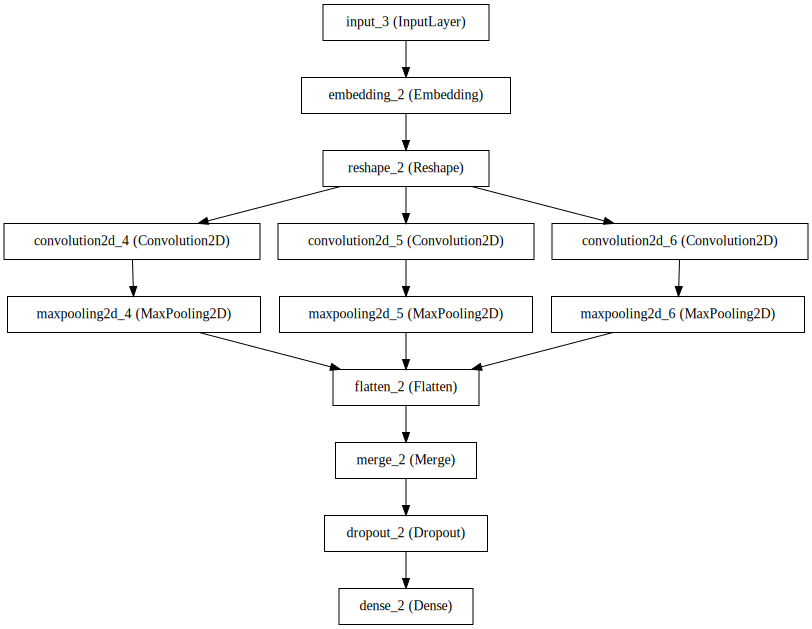

In [21]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 模型输入

In [22]:
print(type(train_y[0]))
train_y_model = np_utils.to_categorical(train_y, nb_classes)
dev_y_model = np_utils.to_categorical(dev_y, nb_classes)
train_X_model = sequence.pad_sequences(train_X, maxlen=max_len)
dev_X_model = sequence.pad_sequences(dev_X, maxlen=max_len)

<class 'int'>


In [23]:
#test 数据
test_index_X= [[word_index[w] if w in word_index else 0 for w in line] for line in test_X]
test_X_model = sequence.pad_sequences(test_index_X,maxlen=max_len)
test_y_model = np_utils.to_categorical(test_y,nb_classes)

In [24]:
def shuffle(X,y):
    index=np.array(range(len(X)))
    np.random.shuffle(index)
    return X[index],y[index]
    

def my_generator(X=None,y=None):
    i = 0
    max_i = int(len(X)/batch_size)
    while True:
        i = i % max_i
        if i ==0:
            X,y = shuffle(X,y)
        x_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield (x_batch,y_batch)
        i = i + 1
    

In [25]:
print (model.layers)
print(model.layers[0].output_shape)
print(model.layers[1].input_shape)

[<keras.engine.topology.InputLayer object at 0x7f86aabae4a8>, <keras.layers.embeddings.Embedding object at 0x7f86aaba97f0>, <keras.layers.core.Reshape object at 0x7f86aaba9780>, <keras.layers.convolutional.Convolution2D object at 0x7f86aa541e10>, <keras.layers.convolutional.Convolution2D object at 0x7f86aabb1e10>, <keras.layers.convolutional.Convolution2D object at 0x7f86aa541a20>, <keras.layers.pooling.MaxPooling2D object at 0x7f86aab8f6d8>, <keras.layers.pooling.MaxPooling2D object at 0x7f86aab9eba8>, <keras.layers.pooling.MaxPooling2D object at 0x7f86aab9ec50>, <keras.layers.core.Flatten object at 0x7f86aab9ecc0>, <keras.engine.topology.Merge object at 0x7f86aac51fd0>, <keras.layers.core.Dropout object at 0x7f86aac51978>, <keras.layers.core.Dense object at 0x7f86aac58550>]
(None, 56)
(None, 56)


In [26]:
#history_data = model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 20*100,nb_epoch=70,verbose=1,validation_data=(test_X_model,test_y_model),callbacks=[history])
history_data = model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 40*100,nb_epoch=100,verbose=1,validation_data=(test_X_model,test_y_model))

Epoch 1/100
4000/4000 [==============================] - 12s - loss: 1.6308 - acc: 0.2567 - val_loss: 1.6016 - val_acc: 0.2430
Epoch 2/100
4000/4000 [==============================] - 12s - loss: 1.5968 - acc: 0.2785 - val_loss: 1.5196 - val_acc: 0.3271
Epoch 3/100
4000/4000 [==============================] - 12s - loss: 1.5314 - acc: 0.3145 - val_loss: 1.5204 - val_acc: 0.3068
Epoch 4/100
4000/4000 [==============================] - 12s - loss: 1.5042 - acc: 0.3335 - val_loss: 1.4821 - val_acc: 0.3394
Epoch 5/100
4000/4000 [==============================] - 12s - loss: 1.4539 - acc: 0.3750 - val_loss: 1.4708 - val_acc: 0.3579
Epoch 6/100
4000/4000 [==============================] - 12s - loss: 1.4136 - acc: 0.3935 - val_loss: 1.4077 - val_acc: 0.3905
Epoch 7/100
4000/4000 [==============================] - 12s - loss: 1.3670 - acc: 0.4152 - val_loss: 1.3835 - val_acc: 0.3991
Epoch 8/100
4000/4000 [==============================] - 12s - loss: 1.3215 - acc: 0.4437 - val_loss: 1.3617 - 

最佳测试成绩： 0.420361990573


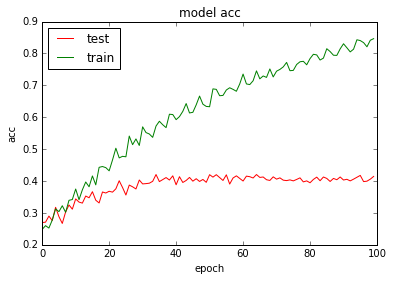

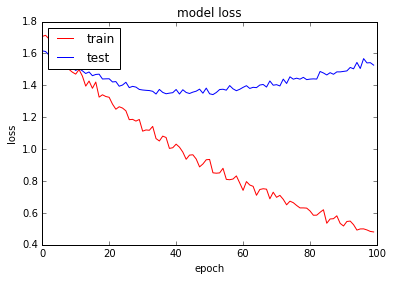

In [30]:
## non-sataic 动态测试
#glove
#Epoch 19/100 2000/2000 [==============================] - 8s - loss: 1.3439 - acc: 0.6145 - val_loss: 1.2428 - val_acc: 0.4629
#Epoch 38/100 2000/2000 [==============================] - 9s - loss: 0.5664 - acc: 0.9005 - val_loss: 1.4114 - val_acc: 0.4511
#Epoch 25/100 2000/2000 [==============================] - 9s - loss: 1.0709 - acc: 0.7110 - val_loss: 1.2304 - val_acc: 0.4661
#Epoch 38/100 2000/2000 [==============================] - 9s - loss: 0.5341 - acc: 0.9125 - val_loss: 1.6058 - val_acc: 0.4566
#Epoch 9/50 2000/2000 [==============================] - 9s - loss: 2.0732 - acc: 0.4635 - val_loss: 1.2695 - val_acc: 0.4597
#google 
#Epoch 54 2000/2000 [==============================] - 9s - loss: 0.6900 - acc: 0.8260 - val_loss: 1.3817 - val_acc: 0.4566
#Epoch 47/70 2000/2000 [==============================] - 9s - loss: 0.7923 - acc: 0.7745 - val_loss: 1.2870 - val_acc: 0.4620
history = history_data.history
print('最佳测试成绩：',max(history['val_acc']))
fig = plt.figure()
plt.plot(history['val_acc'],'r')
plt.plot(history['acc'],'g',label='测试准确率')
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

fig = plt.figure()
plt.plot(history['loss'],color='r')
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

最佳测试成绩： 0.461990950334


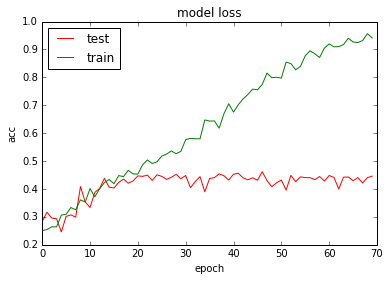

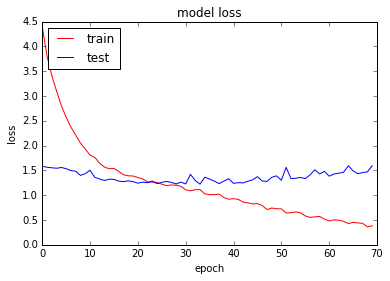

In [109]:
#static:
#最佳测试成绩： 0.453846151608
#epoch 18 2000/2000 [==============================] - 10s - loss: 1.3526 - acc: 0.6155 - val_loss: 1.2579 - val_acc: 0.4643
#epoch 23 2000/2000 [==============================] - 10s - loss: 1.0800 - acc: 0.6980 - val_loss: 1.2576 - val_acc: 0.4543
#epoch 26 2000/2000 [==============================] - 10s - loss: 0.9911 - acc: 0.7440 - val_loss: 1.3089 - val_acc: 0.4575
#Epoch 9/100 2000/2000 [==============================] - 10s - loss: 2.1036 - acc: 0.4565 - val_loss: 1.2884 - val_acc: 0.4552
#Epoch 23/40 2000/2000 [==============================] - 10s - loss: 1.0703 - acc: 0.7220 - val_loss: 1.2691 - val_acc: 0.4557
#Epoch 14/40 2000/2000 [==============================] - 5s - loss: 1.5780 - acc: 0.5405 - val_loss: 1.2548 - val_acc: 0.4570

print('最佳测试成绩：',max(history.test_accuracy))
fig = plt.figure()
plt.plot(history.test_accuracy,'r')
plt.plot(history.train_accuracy,'g',label='测试准确率')
plt.title('model loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

fig = plt.figure()
plt.plot(history.train_losses,color='r')
plt.plot(history.test_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# 实验结果

cnn-static:0.4489 ()
glove 300维度：0.4520
loss: 0.2594 - acc: 0.9935 - val_loss: 1.4543 - val_acc: 0.4575

cnn_non_static:
0.4498(loss=0.7727,acc=0.7438)
0.4643(loss=0.3920,acc = 0.9205)

 16s - loss: 0.5418 - acc: 0.9185 - val_loss: 1.3282 - val_acc: 0.4674
 loss: 0.7181 - acc: 0.8215 - val_loss: 1.2562 - val_acc: 0.4624